### Analysis of the severe slugging data (3W dataset)

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from gtda.pipeline import Pipeline
from gtda.time_series import Resampler
from gtda.diagrams import PersistenceEntropy, Scaler, HeatKernel, BettiCurve
import numpy as np
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters, TakensEmbedding
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
import plotly.express as px
import statistics as stats

This notebook explores the severe slugging events part of the 3W dataset [R.E.V. Vargas et al. J. Pet. Sci. Eng.,
*181*, 106223 (2019)], partially simulated and and partially from offshore data. \
First we read the dataset and, from the multi-variate timeseries, we select only the wellhead pressure (P-TPT). Then we downsample the time series to 3000 points, in order to keep the computational effort for TDA to a manageable level. 

In [6]:
def find_shortest_file(path, label):
    tmp = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        tmp.append(len(data_df[label]))
    return min(tmp)

In [7]:
def read_files(path, label, limit):
    data = []
    os.chdir(path)
    i = 0
    for file in os.listdir():
        data_df = pd.read_csv(file)
        # fill NaN with an interpolated value
        data_df = data_df.interpolate()
        period = int(len(data_df)/limit)
        periodicSampler = Resampler(period=period)
        print(i,file)
        # resample the files to that all of them are the same length (in entries)
        # NOTE: timestamps are omitted and timesteps are going to be different for each resampled time series!
        index_sampled, signal_sampled = periodicSampler.fit_transform_resample(data_df.index, data_df[label])
        data.append(signal_sampled)
        i += 1
    data_T = list(map(list, zip(*data)))
    data = np.array(data_T)
    df = pd.DataFrame.from_records(data_T)
    return data.T, df

In [9]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/", "P-TPT")

12999

In [10]:
slugging_signals, slugging_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/ALL/", "P-TPT",3000)

0 SIMULATED_00035.csv
1 SIMULATED_00021.csv
2 SIMULATED_00009.csv
3 WELL-00014_20170921200114.csv
4 WELL-00014_20170925160218.csv
5 WELL-00014_20170926170228.csv
6 SIMULATED_00008.csv
7 SIMULATED_00020.csv
8 SIMULATED_00034.csv
9 SIMULATED_00022.csv
10 WELL-00014_20170920010042.csv
11 SIMULATED_00036.csv
12 WELL-00014_20170920060228.csv
13 WELL-00014_20170921050404.csv
14 SIMULATED_00037.csv
15 SIMULATED_00023.csv
16 WELL-00014_20170921100155.csv
17 SIMULATED_00027.csv
18 WELL-00001_20170320130025.csv
19 WELL-00014_20170920110053.csv
20 SIMULATED_00033.csv
21 WELL-00014_20170922060124.csv
22 SIMULATED_00032.csv
23 SIMULATED_00026.csv
24 SIMULATED_00018.csv
25 SIMULATED_00030.csv
26 SIMULATED_00024.csv
27 WELL-00014_20170926020340.csv
28 WELL-00014_20171028130000.csv
29 SIMULATED_00025.csv
30 SIMULATED_00031.csv
31 SIMULATED_00019.csv
32 SIMULATED_00056.csv
33 SIMULATED_00042.csv
34 WELL-00014_20170925210042.csv
35 WELL-00014_20171028080000.csv
36 SIMULATED_00043.csv
37 SIMULATED_00057.

In [11]:
PatoBar = 1/100000
slugging_df = slugging_df.apply(lambda x: x*PatoBar) 
slugging_signals = slugging_signals * PatoBar

We have a total of 105 severe slugging events: 33 real events and 75 simulated one (with OLGA)

In [12]:
slugging_df

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,96.17383,108.2988,174.7420,159.2380,163.6436,145.4572,177.5400,105.3062,167.5515,88.11328,...,180.6620,185.6920,126.3246,177.2877,113.0322,199.9919,168.0768,178.6139,201.1752,153.7390
1,96.76311,108.3681,174.5841,159.1861,163.6372,145.4879,177.7650,105.3761,167.6486,86.81970,...,180.8188,185.7704,125.9113,177.3547,112.5648,199.9090,168.0295,178.4102,201.3706,153.7529
2,97.34932,108.4361,174.4556,159.1272,163.6238,145.5183,177.9906,105.4452,167.7342,85.65844,...,180.9651,185.8555,125.5987,177.4126,111.3727,199.8285,167.9745,178.2195,201.5635,153.7604
3,97.93384,108.5042,174.3357,159.0721,163.6229,145.5528,178.2196,105.5107,167.8100,84.64813,...,181.1152,185.9351,125.3948,177.4723,108.4301,199.7467,167.9240,178.0705,201.7437,153.7613
4,98.51336,108.5681,174.2306,158.9737,163.6395,145.5905,178.4324,105.5737,167.8849,83.80443,...,181.2598,185.9948,125.2949,177.5293,105.1093,199.6501,167.8513,177.9159,201.9234,153.7554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,94.53171,102.3036,182.5136,148.4925,143.0031,139.0851,183.3203,107.2557,163.5842,100.70980,...,180.4913,198.2009,192.6270,174.9625,118.9467,201.1888,180.3041,184.2655,203.7540,152.3167
3040,95.12980,102.2921,182.7436,148.2848,143.0901,139.0980,183.1843,107.2109,164.0312,100.93280,...,180.5391,198.0693,192.1176,175.2638,119.1532,201.3474,180.3362,184.3042,203.9058,152.4458
3041,95.72232,102.2805,182.9678,148.1548,143.1250,139.1262,182.9915,107.1630,164.3872,101.14470,...,180.5942,197.9429,191.5884,175.5548,119.3467,201.4928,180.3737,184.3433,204.0186,152.5718
3042,96.31479,102.2690,183.1760,147.8562,143.2103,139.1439,182.8281,107.1125,164.6092,101.34700,...,180.6801,197.8125,191.0758,175.8483,119.5316,201.6354,180.4196,184.3867,204.1487,152.6944


Let's show how one of these time series looks in detail 

freq units: 3.285151E-05 Hz


<AxesSubplot:xlabel='BHP (Bar)', ylabel='count'>

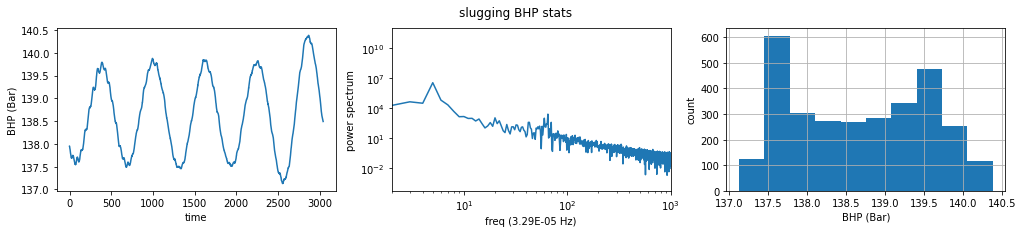

In [13]:
from random import gauss
from random import seed
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot

fig_ss_analysis, data = plt.subplots(1, 3, figsize=(17, 3))
freq_units = 0.1/len(slugging_df[21])
print('freq units: %(units)4E Hz' %{"units":(freq_units)})

fig_ss_analysis.suptitle('slugging BHP stats')
data[0].set_xlabel('time')
data[0].set_ylabel('BHP (Bar)')
data[1].set_xlabel('freq (%(units).2E Hz)' %{"units":(freq_units)})
data[1].set_ylabel('power spectrum')
data[2].set_xlabel('BHP (Bar)')
data[2].set_ylabel('count')

data[1].set_xlim(2,1000)
data[1].set_yscale('log')
data[1].set_xscale('log')

ss_BHP = slugging_df[35]

fft_ss = np.fft.rfft(ss_BHP)
fft_ss_abs = np.abs(fft_ss)
power_spectrum_ss = np.square(fft_ss_abs)


data[0].plot(ss_BHP)
data[1].plot(power_spectrum_ss)
ss_BHP.hist()

In [14]:
# write file for making figures  
file = open("slugging_3W.dat", "w")
for i in ss_BHP:
    tmp = str(i) + "\n"
    file.writelines(tmp)
file.close()

We then perform Takens embedding [F. Takens, Lecture Notes in Mathematics *898* (1981)] to produce a point cloud form the time series.

In [23]:
max_time_delay = 55
max_embedding_dimension = 12
stride = 3

signal = ss_BHP

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )
print('length of signal to analyze', int(len(signal)/stride))
print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")
embedding_dimension = optimal_time_delay
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded)

style = {
            "x_range": [-15, 15],
            "y_range": [-15, 15],
            "z_range": [-5, 5],
            "marker": dict(size=12),
            "xaxis": dict(tickmode="linear", tick0=0, dtick=10),
            "yaxis": dict(tickmode="linear", tick0=-500, dtick=500),
        }

layout = {
        "xaxis": style["xaxis"],
        "yaxis": style["yaxis"],
        "xaxis_range": style["x_range"],
        "yaxis_range": style["y_range"]
    }

plotly_params_layout = {"layout": layout}

#norm =  plot_point_cloud(y_embedded_pca, plotly_params=plotly_params_layout)
#norm

import plotly.graph_objs as gobj

fig = gobj.Figure()
#fig.update_layout(scene=scene)

fig.add_trace(gobj.Scatter3d(
    x=point_cloud[:, 0],
    y=point_cloud[:, 1],
    z=point_cloud[:, 2],
    mode="markers",
    marker={"size": 4,
            "color": list(range(point_cloud.shape[0])),
            "colorscale": "Viridis",
            "opacity": 0.8}
    ))

fig.update_layout(plotly_params.get("layout", layout))


length of signal to analyze 1014
Optimal embedding time delay based on mutual information: 30
Optimal embedding dimension based on false nearest neighbors: 12


NameError: name 'point_cloud' is not defined

In [ ]:
homology_dimensions = (0,1)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
PerDiagram = VRP.fit_transform_plot(y_embedded[None,:,:])

In [ ]:
PE_BHP = PersistenceEntropy()
features = PE_BHP.fit_transform(PerDiagram)
features 

In [ ]:
PE_BHP = PersistenceEntropy(normalize=True)
features = PE_BHP.fit_transform(PerDiagram)
features 

In [ ]:
pers_H0 = []
pers_H1 = []
max_pers_H0 = []
max_pers_H1 = []

for PersDiag in PerDiagram: 
    for point in PersDiag:
        birth = point[0]
        death = point[1]
        dimension = point[2]
        persistence = abs(death - birth)
        pers_H0.extend([persistence] if dimension == 0 else [])
        pers_H1.extend([persistence] if dimension == 1 else [])
    max_pers_H0.append(np.amax(pers_H0))
    max_pers_H1.append(np.amax(pers_H1))

print('Maximum Persistence for BHP:')
print("Max Pers in homology dimension H_0", max_pers_H0 )
print("Max Pers in homology dimension H_1", max_pers_H1 )

In [ ]:
Betti = BettiCurve()
Betti_BHP = Betti.fit_transform_plot(PerDiagram)

print("mean of Betti_H0 for slug flow", stats.mean(Betti_BHP[0,0]))
print("mean of Betti_H1 for slug flow", stats.mean(Betti_BHP[0,1]))

In [ ]:
# write file for making figures  
file1 = open("slugW3_Pers_H0.dat", "w")
file2 = open("slugW3_Pers_H1.dat", "w")
for i in PerDiagram[0,:]:
    if i[2] == 0:
        tmp = str(i[0]) + str(' ') + str(i[1]) + "\n"
        file1.writelines(tmp)
    elif i[2] == 1:
        tmp = str(i[0]) + str(' ') + str(i[1]) + "\n"
        file2.writelines(tmp)
file1.close()
file2.close()

In [ ]:
def batch_analyzer(input_df, stride, max_embedding_dimension, max_time_delay):
    max_time_delay = int(max_time_delay)
    max_embedding_dimension = int(max_embedding_dimension)
    homology_dimensions = (0, 1)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
    pca = PCA(n_components=3)
    PE_signal = PersistenceEntropy()
    PE_norm = PersistenceEntropy(normalize=True)

    entropies = []
    norm_entropies = []
    diagrams = []
    point_clouds_pca = []
    i = 0
    
    print('max time delay:',max_time_delay, 'max dim:',max_embedding_dimension)
    
    for timeserie in input_df:
        
        i += 1
        optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
            input_df[timeserie], max_time_delay, max_embedding_dimension, stride=stride
            )
        if optimal_embedding_dimension < 3:
            optimal_embedding_dimension = 3
            
        print('analyzing nr.',i, 'progress:',int(100*i/len(input_df.columns)),'%', 'dim',optimal_embedding_dimension,'delay', optimal_time_delay)
    return

In [ ]:
batch_analyzer(slugging_df, 3, 20, 130)

In [ ]:
TE = TakensEmbedding(time_delay=125, dimension=7, stride=3)
homology_dimensions = (0, 1)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
PE = PersistenceEntropy()
PE_norm = PersistenceEntropy(normalize=True)
Betti = BettiCurve()

slugging_point_cloud  = TE.fit_transform(slugging_signals)
slugging_diagrams = VRP.fit_transform(slugging_point_cloud)
slugging_entropy = PE.fit_transform(slugging_diagrams)
slugging_entropynorm = PE_norm.fit_transform(slugging_diagrams)
slugging_Betti = Betti.fit_transform(slugging_diagrams)

In [ ]:
tmp_entropies = slugging_entropy
Entropy_H0 = []
Entropy_H1 = []
tmp_normalized = slugging_entropynorm
Entropy_H0_norm = []
Entropy_H1_norm = []

for item in tmp_entropies:
    Entropy_H0.append(item[0])
    Entropy_H1.append(item[1])

for item in tmp_normalized:
    Entropy_H0_norm.append(item[0])
    Entropy_H1_norm.append(item[1])
    
Entropy_H1_series = pd.Series(Entropy_H1)
Entropy_H1_norm_series = pd.Series(Entropy_H1_norm)

entropies, ts = plt.subplots(2,figsize=(10,8),sharex = True)

entropies.suptitle('Slugging flow dataset persistent entropies')
ts[1].set_xlabel("# timeseries")
ts[0].set_ylabel('Entropy')
ts[1].set_ylabel('normalized  Entropy')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(Entropy_H1,'r-')
ts[0].plot(Entropy_H1_series.rolling(20).mean(), 'g-')
ts[0].plot(Entropy_H0,'b-')

ts[1].plot(Entropy_H1_norm,'r-')
ts[1].plot(Entropy_H1_norm_series.rolling(20).mean(), 'g-')
ts[1].plot(Entropy_H0_norm,'b-')

In [ ]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))
stats_entropy.suptitle('Normal operations dataset persistent entropies')

data[0].set_xlabel('Entropy H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Entropy H$_1$")
data[1].set_ylabel('count')

#data[0].set_xlim(8,10)
#data[1].set_xlim(0,8)
data[0].hist(Entropy_H0, bins=25)
data[1].hist(Entropy_H1, bins=25)

plt.tight_layout()

In [ ]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))
stats_entropy.suptitle('Normal operations dataset normalized persistent entropies')

data[0].set_xlabel('Normalized Entropy H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Normalized Entropy H$_1$")
data[1].set_ylabel('count')

data[0].hist(Entropy_H0_norm, bins=20)
data[1].hist(Entropy_H1_norm, bins=20)

plt.tight_layout()

In [ ]:
slugging_entropy.shape

In [ ]:
import statistics as stats
meanBettiH0 = []
medianBettiH0 = []
modeBettiH0 = []

for i in range(len(slugging_Betti[:,0,0])):
    meanBettiH0.append(stats.mean(slugging_Betti[i,0,:]))
    medianBettiH0.append(stats.median(slugging_Betti[i,0,:]))
    modeBettiH0.append(stats.mode(slugging_Betti[i,0,:]))
    
    
figBetti = px.line()
figBetti.add_scatter(y=(meanBettiH0), name="Mean of Betti curve H_0")
figBetti.add_scatter(y=(medianBettiH0), name="Median of Betti curve H_0")
figBetti.add_scatter(y=(modeBettiH0),name="Mode of Betti curve H_0")
figBetti.show()

In [ ]:
meanBettiH1 = []
medianBettiH1 = []
modeBettiH1 = []

for i in range(len(slugging_Betti[:,1,0])):
    meanBettiH1.append(stats.mean(slugging_Betti[i,1,:]))
    medianBettiH1.append(stats.median(slugging_Betti[i,1,:]))
    modeBettiH1.append(stats.mode(slugging_Betti[i,1,:]))
    
    
figBetti = px.line()
figBetti.add_scatter(y=(meanBettiH1), name="Mean of Betti curve H_1")
figBetti.add_scatter(y=(medianBettiH1), name="Median of Betti curve H_1")
figBetti.add_scatter(y=(modeBettiH1),name="Mode of Betti curve H_1")
figBetti.show()

In [ ]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))
stats_entropy.suptitle('Normal operations dataset - Means of Betti curves')

data[0].set_xlabel('Mean of Betti Curve for H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Mean of Betti Curve for H$_1$")
data[1].set_ylabel('count')

data[0].hist(meanBettiH0, bins=20)
data[1].hist(meanBettiH1)

plt.tight_layout()

In [ ]:
pers_H1 = []
pers_H0 = []
max_pers_H0 = []
max_pers_H1 = []

for PersDiag in slugging_diagrams: 
    for point in PersDiag:
        birth = point[0]
        death = point[1]
        dimension = point[2]
        persistence = abs(death - birth)
        pers_H0.extend([persistence] if dimension == 0 else [])
        pers_H1.extend([persistence] if dimension == 1 else [])
    max_pers_H0.append(np.amax(pers_H0))
    max_pers_H1.append(np.amax(pers_H1))
    pers_H0 = []
    pers_H1 = []
           
fig = px.line(title='Maximum Persistence for slugging BHP')
fig.add_scatter(y=max_pers_H1, name="Max Pers in homology dimension H_1")
fig.add_scatter(y=max_pers_H0, name="Max Pers in homology dimension H_0")

fig.show() 

In [ ]:
stats_entropy, data = plt.subplots(1, 2,figsize=(10,4))
stats_entropy.suptitle('Normal operations dataset - Max Persistence')

data[0].set_xlabel('Mean of Betti Curve for H$_0$')
data[0].set_ylabel('count')
data[1].set_xlabel("Mean of Betti Curve for H$_1$")
data[1].set_ylabel('count')

data[0].hist(max_pers_H0, bins = 25)
data[1].hist(max_pers_H1, bins = 25)

plt.tight_layout()

In [ ]:
VRP.plot(Xt=slugging_diagrams, sample=38)

In [ ]:
pca = PCA(n_components=3)
pca_slugging = pca.fit_transform(slugging_point_cloud[27])
plot_point_cloud(pca_slugging)

In [ ]:
PE(Xt=slugging_diagrams, sample=38)